In [1]:
%pylab inline
import sys; sys.path.insert(0, "../")
import numpy as np
import time

from emcee import autocorr
from ensemble_sampler import *

Populating the interactive namespace from numpy and matplotlib


### Example of sampling from a multivariate gaussian

In [2]:
dim = 2
nwalkers = 100
niters = 1000

In [3]:
mu = np.random.randn(dim)

cov = 0.5 - np.random.rand(dim ** 2).reshape((dim, dim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov,cov)

t_dist = MultivariateGaussian(cov=cov, mu=mu, dim=dim)

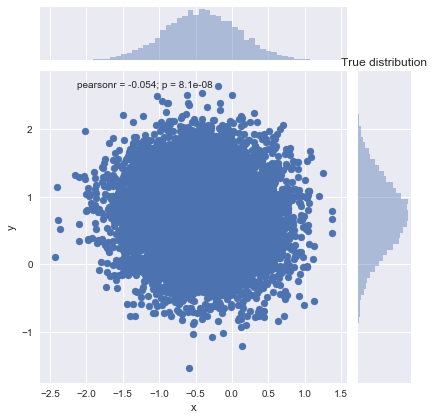

In [4]:
import pandas
import seaborn as sns
data = np.empty([10000, 2])
for i in range(10000):
    data[i] = np.random.multivariate_normal(mean=mu, cov=cov)
df = pandas.DataFrame(data, columns=['x', 'y'])
sns.jointplot(x='x', y='y', data=df)
sns.plt.title('True distribution')

##### Non-pCN, proposal scale=0.4. 

In [5]:
proposal = PCNWalkMove(s=None, scale=0.4)
sampler = Sampler(dim=dim, t_dist=t_dist, proposal=proposal, nwalkers=nwalkers)
# first run 100 steps and use the location as p0
hist = sampler.run_mcmc(100, p0=np.random.randn(dim*nwalkers).reshape([nwalkers, dim]))
p0 = hist.curr_pos

sampler.reset()
sampler.proposal.s = 3

start = time.time()
hist = sampler.run_mcmc(niters, p0=p0)
end = time.time()
print 'finishes in about %.2f seconds' % float(end - start)

finishes in about 13.75 seconds


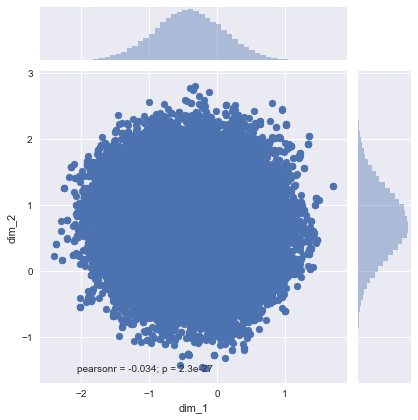

In [6]:
hist.plot_scatter(dim=[[0, 1]])

In [7]:
hist.acceptance_rate.mean()

0.76509000000000027

In [8]:
# typically only reliable for niters ~ 10000
hist.auto_corr()

array([ 19.33599336,  19.33482106])

In [9]:
history = hist.get("chain")[0]
N = len(history)
start_from = 0

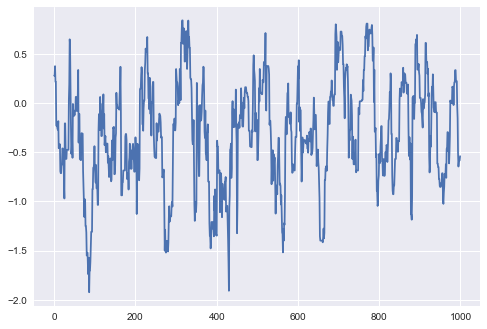

In [10]:
plt.plot(np.arange(N - start_from), history[start_from:, 0])

##### pCN, proposal beta=0.4. 

In [11]:
proposal = PCNWalkMove(s=None, scale=0.4)
sampler = Sampler(dim=dim, t_dist=t_dist, proposal=proposal, nwalkers=nwalkers)
# first run 100 steps and use the location as p0
hist = sampler.run_mcmc(100, p0=np.random.randn(dim*nwalkers).reshape([nwalkers, dim]))
p0 = hist.curr_pos

sampler.reset()
sampler.proposal.s = 3
sampler.proposal.beta = 0.4

start = time.time()
hist = sampler.run_mcmc(niters, p0=p0)
end = time.time()
print 'finishes in about %.2f seconds' % float(end - start)

finishes in about 13.01 seconds


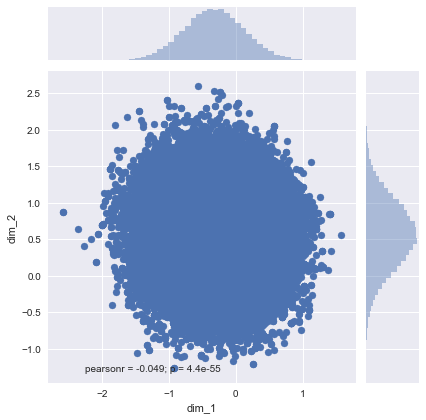

In [12]:
hist.plot_scatter(dim=[[0, 1]])

In [13]:
hist.acceptance_rate.mean()

0.66176000000000001

In [14]:
hist.auto_corr()

array([ 7.12498482,  7.89459638])